# Apple Stock Price (2014-2024)

In [164]:
!pip install neuralforecast

In [165]:
#!pip install --upgrade utilsforecast

In [166]:
#!pip install datasetsforecast

In [167]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [168]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import  TFT, NBEATSx, NHITS
from neuralforecast.losses.pytorch import MQLoss, MAE, MSE
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic, augment_calendar_df
from neuralforecast.losses.numpy import mae, mse
from sklearn.preprocessing import MinMaxScaler

In [169]:
import os
#os.chdir("/content/sample_data")

In [170]:
df_1 = pd.read_csv("/content/sample_data/AAPL_Apple_Inc..csv", parse_dates=['Date'])

In [171]:
df_1['pct_chg'] = df_1['Close'].pct_change() * 100
df_1['ratechg'] = df_1['pct_chg'].apply(lambda x: 0.01 * x)

In [172]:
df_1.drop(columns=['pct_chg'],inplace=True)

In [173]:
df_1 = df_1.iloc[1:].reset_index(drop=True)

In [174]:
df_1 = df_1.rename(columns={'ratechg': 'y', 'Date': 'ds'})
df_1['unique_id'] = "apple_inc"

In [175]:
# List of independent variables
independent_vars = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

# Correlation matrix with 'Close'
corr_with_close = df_1[independent_vars + ['Close']].corr()['Close'].sort_values(ascending=False)
print("Correlation with Close:")
print(corr_with_close)

Correlation with Close:
Close        1.000000
Adj Close    0.999964
Low          0.999856
High         0.999849
Open         0.999686
Volume      -0.494969
Name: Close, dtype: float64


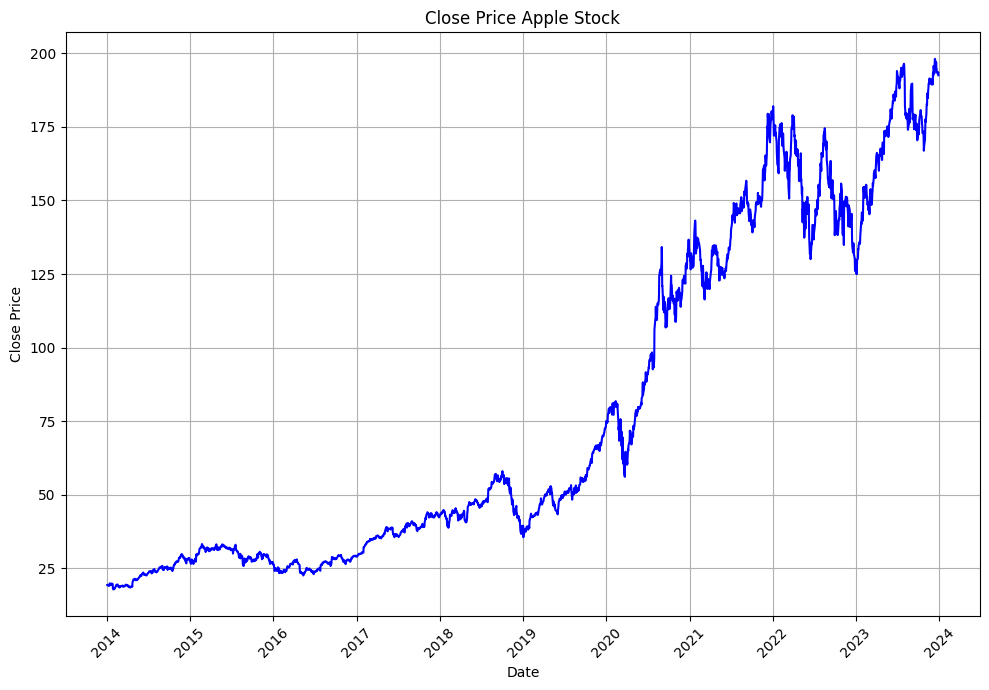

In [176]:
plt.figure(figsize=(10, 7))
plt.plot(df_1['ds'], df_1['Close'], label='Close', color='blue')

plt.title('Close Price Apple Stock')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

In [177]:
test_size = 100
val_size = 200
train_size = len(df_1) - val_size - test_size

train_df = df_1.iloc[:train_size]
val_df = df_1.iloc[train_size:train_size + val_size]
test_df = df_1.iloc[train_size + val_size:]

train_val_df = pd.concat([train_df, val_df])

exogenous_vars = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
train_means = train_df[exogenous_vars].mean()
train_stds = train_df[exogenous_vars].std()

train_val_df[exogenous_vars] = (train_val_df[exogenous_vars] - train_means) / train_stds
test_df[exogenous_vars] = (test_df[exogenous_vars] - train_means) / train_stds

<ipython-input-177-8fc96433b3e2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[exogenous_vars] = (test_df[exogenous_vars] - train_means) / train_stds


# Horizon 3

In [178]:
horizons = 3

models = [TFT(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=10,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
         NBEATSx(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
          NHITS(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        )]

nf = NeuralForecast(
    models=models,
    freq='B')

nf.fit(df=train_val_df, val_size=val_size)

Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MSE                      | 0      | train
1 | padder_train            | ConstantPad1d            |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.3 M  | train
-------------------------------------------------------
3.3 M     Trainable params
693       Non-trainable params
3.3 M     Total params
13.235    Total estimated model params size (MB)
31        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.1 M  | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.422    Total estimated model params size (MB)
34        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [179]:
y_test = test_df[['ds', 'y']].iloc[:3]

earliest_date = test_df.loc[y_test.index, 'ds'].min()

previous_day_data = df_1[df_1['ds'] < earliest_date].sort_values('ds').iloc[-1:]
previous_day_data = previous_day_data[['unique_id', 'ds', 'Close']]

Y_hat_df_1 = pd.concat([
    previous_day_data,
    test_df.loc[y_test.index, ['unique_id', 'ds']].assign(y=y_test['y'].values)
], ignore_index=True)


Y_hat_predictions = Y_hat_df[['unique_id', 'ds', 'TFT', 'NBEATSx', 'NHITS']]

Y_hat_df = pd.merge(
    Y_hat_df_1,
    Y_hat_predictions,
    how='left',
    on=['unique_id', 'ds']
)

Y_hat_df = pd.merge(
    Y_hat_df,
    df_1[['unique_id', 'ds', 'Close']],
    how='left',
    on=['unique_id', 'ds']
)

Y_hat_df['Close'] = Y_hat_df['Close_x'].combine_first(Y_hat_df['Close_y'])
Y_hat_df.drop(columns=['Close_x', 'Close_y'], inplace=True)

In [180]:
Y_hat_df_2 = Y_hat_df.copy()

previous_close = Y_hat_df_2['Close'].iloc[0]

for i in range(1, len(Y_hat_df_1)):
    Y_hat_df_2.at[i, 'TFT_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'TFT'])
    Y_hat_df_2.at[i, 'NBEATs_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NBEATSx'])
    Y_hat_df_2.at[i, 'NHITS_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NHITS'])


    previous_close = Y_hat_df_2.at[i, 'Close']

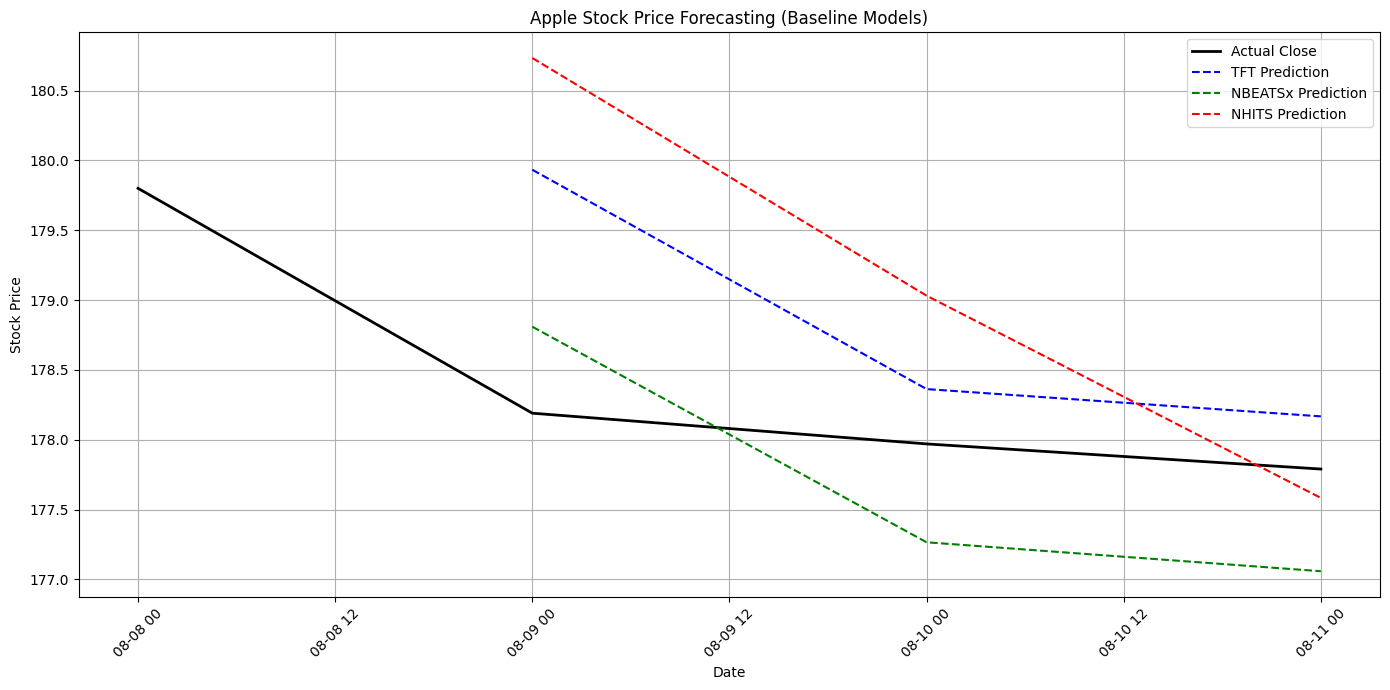

In [181]:
plt.figure(figsize=(14, 7))
plt.plot(Y_hat_df['ds'], Y_hat_df_2['Close'], label='Actual Close', color='black', linewidth=2)

plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['TFT_Close'], label='TFT Prediction', color='blue', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NBEATs_Close'], label='NBEATSx Prediction', color='green', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NHITS_Close'], label='NHITS Prediction', color='red', linestyle='--')

plt.title('Apple Stock Price Forecasting (Baseline Models)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [182]:
mse_TFT = mse(Y_hat_df['y'], Y_hat_df['TFT'])
mae_TFT = mae(Y_hat_df['y'], Y_hat_df['TFT'])
mse_NBEATSx = mse(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mae_NBEATSx = mae(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mse_NHITS = mse(Y_hat_df['y'], Y_hat_df['NHITS'])
mae_NHITS = mae(Y_hat_df['y'], Y_hat_df['NHITS'])

In [183]:
print(f"MSE TFT: {mse_TFT}")
print(f"MAE TFT: {mae_TFT}")
print(f"MSE NBEATSx: {mse_NBEATSx}")
print(f"MAE NBEATSx: {mae_NBEATSx}")
print(f"MSE NHITS: {mse_NHITS}")
print(f"MAE NHITS: {mae_NHITS}")

MSE TFT: 3.44410709322782e-05
MAE TFT: 0.0046722999114151564
MSE NBEATSx: 1.4794881574150756e-05
MAE NBEATSx: 0.0038358520799282405
MSE NHITS: 7.897079253566494e-05
MAE NHITS: 0.007087631234249862


# Horizon 5

In [184]:
# Set horizon to forecast the entire test set
horizons = 5

models = [TFT(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=10,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
         NBEATSx(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
          NHITS(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        )]

nf = NeuralForecast(
    models=models,
    freq='B')

# Fit the model using training and validation sets
nf.fit(df=train_val_df, val_size=val_size)

# Perform cross-validation using the same val_size and test_size as above
Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MSE                      | 0      | train
1 | padder_train            | ConstantPad1d            |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.3 M  | train
-------------------------------------------------------
3.3 M     Trainable params
1.1 K     Non-trainable params
3.3 M     Total params
13.258    Total estimated model params size (MB)
31        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.1 M  | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.428    Total estimated model params size (MB)
34        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [185]:
y_test = test_df[['ds', 'y']].iloc[:5]
earliest_date = test_df.loc[y_test.index, 'ds'].min()

previous_day_data = df_1[df_1['ds'] < earliest_date].sort_values('ds').iloc[-1:]
previous_day_data = previous_day_data[['unique_id', 'ds', 'Close']]

Y_hat_df_1 = pd.concat([
    previous_day_data,
    test_df.loc[y_test.index, ['unique_id', 'ds']].assign(y=y_test['y'].values)
], ignore_index=True)


Y_hat_predictions = Y_hat_df[['unique_id', 'ds', 'TFT', 'NBEATSx', 'NHITS']]

Y_hat_df = pd.merge(
    Y_hat_df_1,
    Y_hat_predictions,
    how='left',
    on=['unique_id', 'ds']
)
Y_hat_df = pd.merge(
    Y_hat_df,
    df_1[['unique_id', 'ds', 'Close']],
    how='left',
    on=['unique_id', 'ds']
)
Y_hat_df['Close'] = Y_hat_df['Close_x'].combine_first(Y_hat_df['Close_y'])
Y_hat_df.drop(columns=['Close_x', 'Close_y'], inplace=True)

In [186]:
Y_hat_df_2 = Y_hat_df.copy()
previous_close = Y_hat_df_2['Close'].iloc[0]

for i in range(1, len(Y_hat_df_1)):
    Y_hat_df_2.at[i, 'TFT_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'TFT'])
    Y_hat_df_2.at[i, 'NBEATs_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NBEATSx'])
    Y_hat_df_2.at[i, 'NHITS_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NHITS'])
    previous_close = Y_hat_df_2.at[i, 'Close']

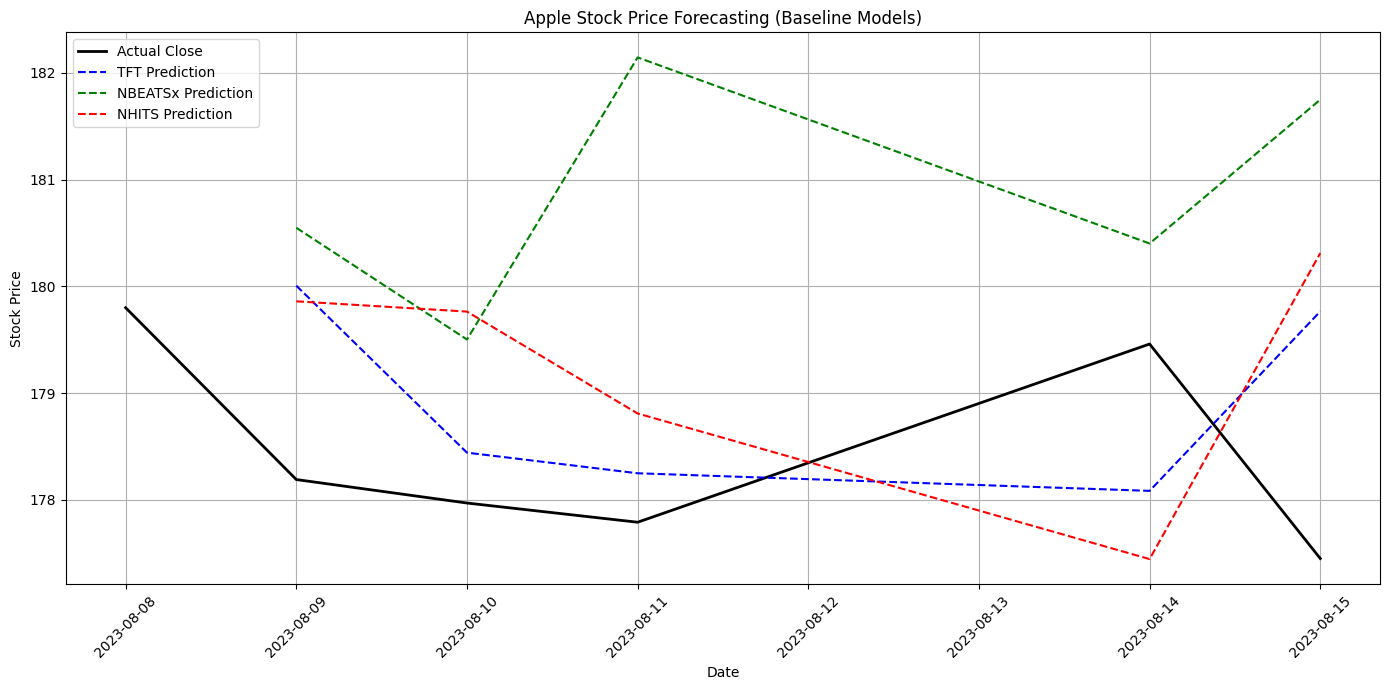

In [187]:
plt.figure(figsize=(14, 7))
plt.plot(Y_hat_df['ds'], Y_hat_df_2['Close'], label='Actual Close', color='black', linewidth=2)
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['TFT_Close'], label='TFT Prediction', color='blue', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NBEATs_Close'], label='NBEATSx Prediction', color='green', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NHITS_Close'], label='NHITS Prediction', color='red', linestyle='--')

plt.title('Apple Stock Price Forecasting (Baseline Models)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [188]:
mse_TFT = mse(Y_hat_df['y'], Y_hat_df['TFT'])
mae_TFT = mae(Y_hat_df['y'], Y_hat_df['TFT'])
mse_NBEATSx = mse(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mae_NBEATSx = mae(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mse_NHITS = mse(Y_hat_df['y'], Y_hat_df['NHITS'])
mae_NHITS = mae(Y_hat_df['y'], Y_hat_df['NHITS'])

In [189]:
print(f"MSE TFT: {mse_TFT}")
print(f"MAE TFT: {mae_TFT}")
print(f"MSE NBEATSx: {mse_NBEATSx}")
print(f"MAE NBEATSx: {mae_NBEATSx}")
print(f"MSE NHITS: {mse_NHITS}")
print(f"MAE NHITS: {mae_NHITS}")

MSE TFT: 6.842272205912026e-05
MAE TFT: 0.007194757145323272
MSE NBEATSx: 0.0002894545324537162
MAE NBEATSx: 0.01509080231188038
MSE NHITS: 0.00012063553313400072
MAE NHITS: 0.010472630090505298


# Horizon 10

In [190]:
horizons = 10

models = [TFT(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=10,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
         NBEATSx(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
          NHITS(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        )]

nf = NeuralForecast(
    models=models,
    freq='B')

nf.fit(df=train_val_df, val_size=val_size)

Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MSE                      | 0      | train
1 | padder_train            | ConstantPad1d            |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.3 M  | train
-------------------------------------------------------
3.3 M     Trainable params
2.2 K     Non-trainable params
3.3 M     Total params
13.313    Total estimated model params size (MB)
31        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.1 M  | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.447    Total estimated model params size (MB)
34        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [191]:
y_test = test_df[['ds', 'y']].iloc[:10]
earliest_date = test_df.loc[y_test.index, 'ds'].min()

previous_day_data = df_1[df_1['ds'] < earliest_date].sort_values('ds').iloc[-1:]
previous_day_data = previous_day_data[['unique_id', 'ds', 'Close']]

Y_hat_df_1 = pd.concat([
    previous_day_data,
    test_df.loc[y_test.index, ['unique_id', 'ds']].assign(y=y_test['y'].values)
], ignore_index=True)


Y_hat_predictions = Y_hat_df[['unique_id', 'ds', 'TFT', 'NBEATSx', 'NHITS']]
Y_hat_df = pd.merge(
    Y_hat_df_1,
    Y_hat_predictions,
    how='left',
    on=['unique_id', 'ds']
)

Y_hat_df = pd.merge(
    Y_hat_df,
    df_1[['unique_id', 'ds', 'Close']],
    how='left',
    on=['unique_id', 'ds']
)

Y_hat_df['Close'] = Y_hat_df['Close_x'].combine_first(Y_hat_df['Close_y'])
Y_hat_df.drop(columns=['Close_x', 'Close_y'], inplace=True)

In [192]:
Y_hat_df_2 = Y_hat_df.copy()
previous_close = Y_hat_df_2['Close'].iloc[0]

for i in range(1, len(Y_hat_df_1)):
    Y_hat_df_2.at[i, 'TFT_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'TFT'])
    Y_hat_df_2.at[i, 'NBEATs_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NBEATSx'])
    Y_hat_df_2.at[i, 'NHITS_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NHITS'])
    previous_close = Y_hat_df_2.at[i, 'Close']

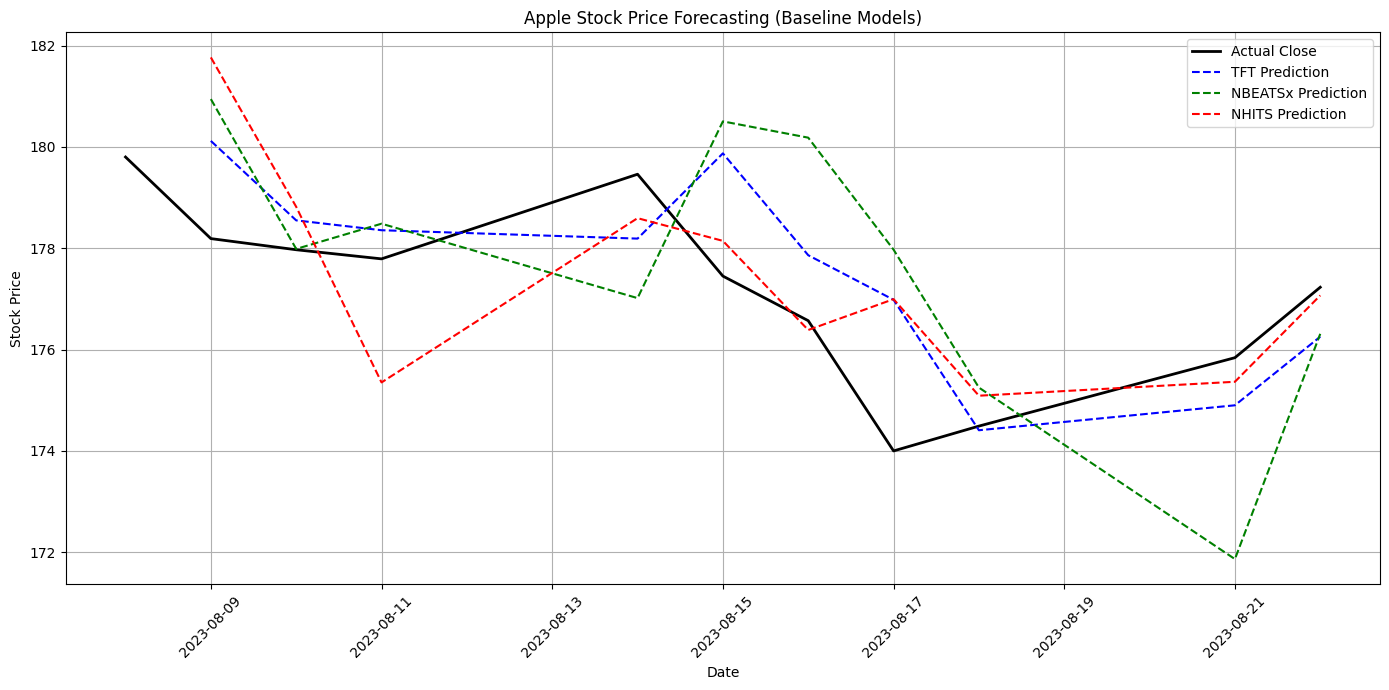

In [193]:
plt.figure(figsize=(14, 7))
plt.plot(Y_hat_df['ds'], Y_hat_df_2['Close'], label='Actual Close', color='black', linewidth=2)
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['TFT_Close'], label='TFT Prediction', color='blue', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NBEATs_Close'], label='NBEATSx Prediction', color='green', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NHITS_Close'], label='NHITS Prediction', color='red', linestyle='--')

plt.title('Apple Stock Price Forecasting (Baseline Models)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [194]:
mse_TFT = mse(Y_hat_df['y'], Y_hat_df['TFT'])
mae_TFT = mae(Y_hat_df['y'], Y_hat_df['TFT'])
mse_NBEATSx = mse(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mae_NBEATSx = mae(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mse_NHITS = mse(Y_hat_df['y'], Y_hat_df['NHITS'])
mae_NHITS = mae(Y_hat_df['y'], Y_hat_df['NHITS'])

In [195]:
print(f"MSE TFT: {mse_TFT}")
print(f"MAE TFT: {mae_TFT}")
print(f"MSE NBEATSx: {mse_NBEATSx}")
print(f"MAE NBEATSx: {mae_NBEATSx}")
print(f"MSE NHITS: {mse_NHITS}")
print(f"MAE NHITS: {mae_NHITS}")

MSE TFT: 7.671123421127088e-05
MAE TFT: 0.007336382674380781
MSE NBEATSx: 0.00022133267658465346
MAE NBEATSx: 0.012527877597615611
MSE NHITS: 9.533894296917812e-05
MAE NHITS: 0.0072171803505651


# Horizon 22

In [196]:
horizons = 22

models = [TFT(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=10,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
         NBEATSx(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
          NHITS(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        )]

nf = NeuralForecast(
    models=models,
    freq='B')

nf.fit(df=train_val_df, val_size=val_size)

Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MSE                      | 0      | train
1 | padder_train            | ConstantPad1d            |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.4 M  | train
-------------------------------------------------------
3.4 M     Trainable params
5.3 K     Non-trainable params
3.4 M     Total params
13.449    Total estimated model params size (MB)
31        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.1 M  | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.490    Total estimated model params size (MB)
34        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [197]:
y_test = test_df[['ds', 'y']].iloc[:22]
earliest_date = test_df.loc[y_test.index, 'ds'].min()

previous_day_data = df_1[df_1['ds'] < earliest_date].sort_values('ds').iloc[-1:]
previous_day_data = previous_day_data[['unique_id', 'ds', 'Close']]

Y_hat_df_1 = pd.concat([
    previous_day_data,
    test_df.loc[y_test.index, ['unique_id', 'ds']].assign(y=y_test['y'].values)
], ignore_index=True)


Y_hat_predictions = Y_hat_df[['unique_id', 'ds', 'TFT', 'NBEATSx', 'NHITS']]
Y_hat_df = pd.merge(
    Y_hat_df_1,
    Y_hat_predictions,
    how='left',
    on=['unique_id', 'ds']
)

Y_hat_df = pd.merge(
    Y_hat_df,
    df_1[['unique_id', 'ds', 'Close']],
    how='left',
    on=['unique_id', 'ds']
)

Y_hat_df['Close'] = Y_hat_df['Close_x'].combine_first(Y_hat_df['Close_y'])
Y_hat_df.drop(columns=['Close_x', 'Close_y'], inplace=True)

In [198]:

Y_hat_df_2 = Y_hat_df.copy()
previous_close = Y_hat_df_2['Close'].iloc[0]

for i in range(1, len(Y_hat_df_1)):
    Y_hat_df_2.at[i, 'TFT_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'TFT'])
    Y_hat_df_2.at[i, 'NBEATs_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NBEATSx'])
    Y_hat_df_2.at[i, 'NHITS_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NHITS'])
    previous_close = Y_hat_df_2.at[i, 'Close']

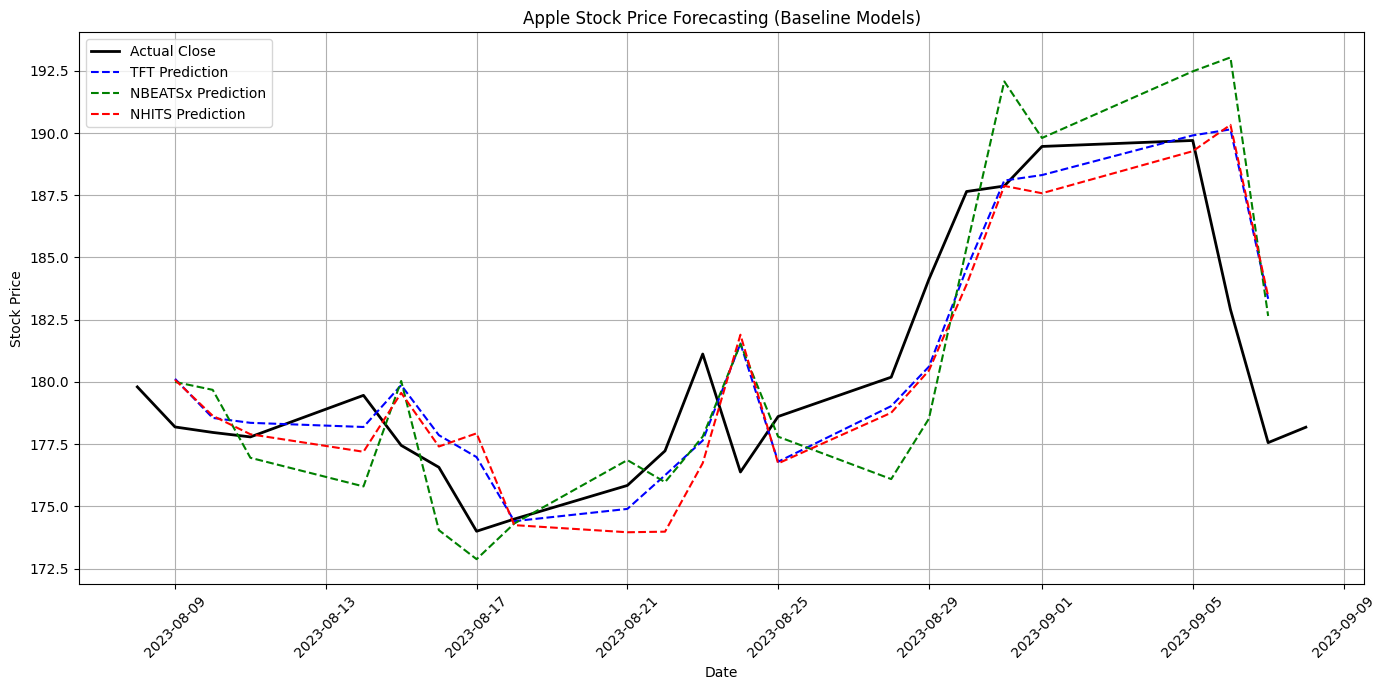

In [199]:
plt.figure(figsize=(14, 7))
plt.plot(Y_hat_df['ds'], Y_hat_df_2['Close'], label='Actual Close', color='black', linewidth=2)
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['TFT_Close'], label='TFT Prediction', color='blue', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NBEATs_Close'], label='NBEATSx Prediction', color='green', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NHITS_Close'], label='NHITS Prediction', color='red', linestyle='--')

plt.title('Apple Stock Price Forecasting (Baseline Models)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [200]:
mse_TFT = mse(Y_hat_df['y'], Y_hat_df['TFT'])
mae_TFT = mae(Y_hat_df['y'], Y_hat_df['TFT'])
mse_NBEATSx = mse(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mae_NBEATSx = mae(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mse_NHITS = mse(Y_hat_df['y'], Y_hat_df['NHITS'])
mae_NHITS = mae(Y_hat_df['y'], Y_hat_df['NHITS'])

In [201]:
print(f"MSE TFT: {mse_TFT}")
print(f"MAE TFT: {mae_TFT}")
print(f"MSE NBEATSx: {mse_NBEATSx}")
print(f"MAE NBEATSx: {mae_NBEATSx}")
print(f"MSE NHITS: {mse_NHITS}")
print(f"MAE NHITS: {mae_NHITS}")

MSE TFT: 0.00025086517103477593
MAE TFT: 0.012036533640911522
MSE NBEATSx: 0.0003970899772587964
MAE NBEATSx: 0.015809192264406885
MSE NHITS: 0.0003148843374887244
MAE NHITS: 0.014049408444989248


# Horizon 50

In [212]:
horizons = 50

models = [TFT(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=10,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
         NBEATSx(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
          NHITS(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        )]

nf = NeuralForecast(
    models=models,
    freq='B')

nf.fit(df=train_val_df, val_size=val_size)

Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MSE                      | 0      | train
1 | padder_train            | ConstantPad1d            |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.4 M  | train
-------------------------------------------------------
3.4 M     Trainable params
14.7 K    Non-trainable params
3.4 M     Total params
13.774    Total estimated model params size (MB)
31        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.1 M  | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.591    Total estimated model params size (MB)
34        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [213]:
y_test = test_df[['ds', 'y']].iloc[:50]
earliest_date = test_df.loc[y_test.index, 'ds'].min()

previous_day_data = df_1[df_1['ds'] < earliest_date].sort_values('ds').iloc[-1:]
previous_day_data = previous_day_data[['unique_id', 'ds', 'Close']]

Y_hat_df_1 = pd.concat([
    previous_day_data,
    test_df.loc[y_test.index, ['unique_id', 'ds']].assign(y=y_test['y'].values)
], ignore_index=True)


Y_hat_predictions = Y_hat_df[['unique_id', 'ds', 'TFT', 'NBEATSx', 'NHITS']]

Y_hat_df = pd.merge(
    Y_hat_df_1,
    Y_hat_predictions,
    how='left',
    on=['unique_id', 'ds']
)

Y_hat_df = pd.merge(
    Y_hat_df,
    df_1[['unique_id', 'ds', 'Close']],
    how='left',
    on=['unique_id', 'ds']
)

Y_hat_df['Close'] = Y_hat_df['Close_x'].combine_first(Y_hat_df['Close_y'])
Y_hat_df.drop(columns=['Close_x', 'Close_y'], inplace=True)



Y_hat_df_2 = Y_hat_df.copy()


previous_close = Y_hat_df_2['Close'].iloc[0]

for i in range(1, len(Y_hat_df_1)):
    Y_hat_df_2.at[i, 'TFT_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'TFT'])
    Y_hat_df_2.at[i, 'NBEATs_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NBEATSx'])
    Y_hat_df_2.at[i, 'NHITS_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NHITS'])
    previous_close = Y_hat_df_2.at[i, 'Close']

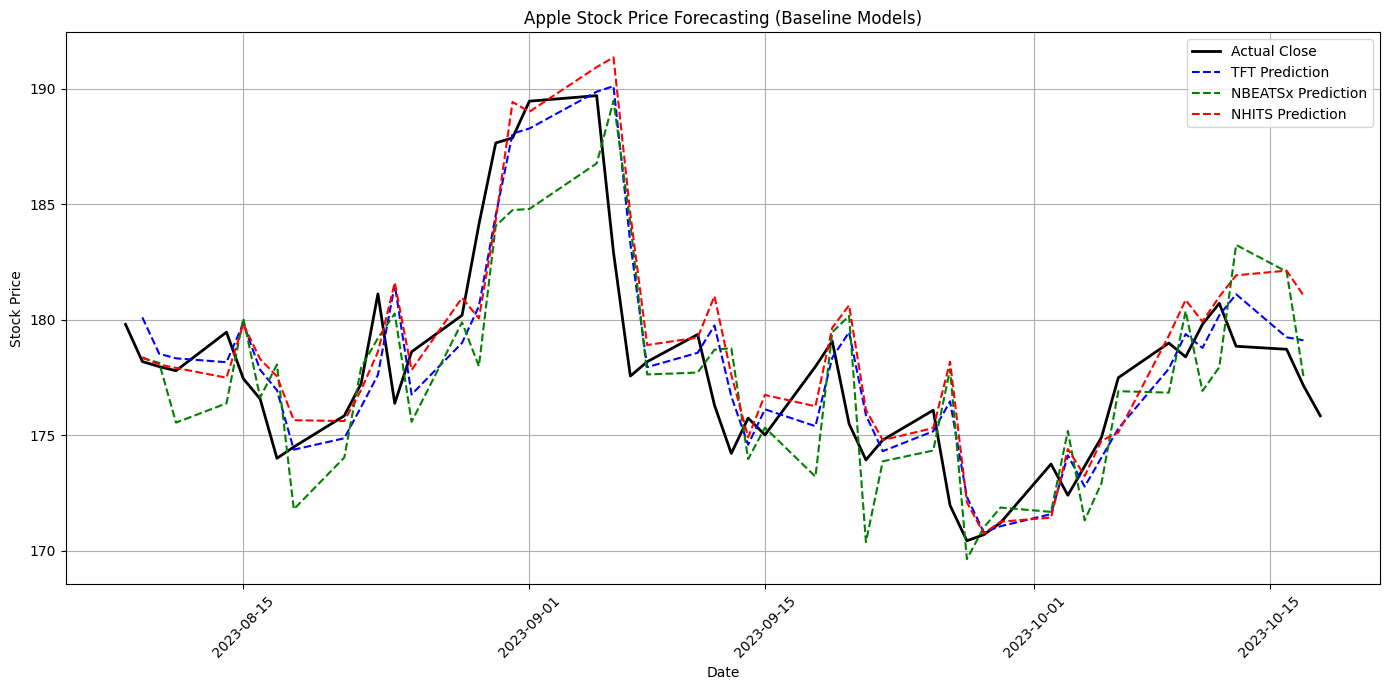

In [214]:
plt.figure(figsize=(14, 7))
plt.plot(Y_hat_df['ds'], Y_hat_df_2['Close'], label='Actual Close', color='black', linewidth=2)
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['TFT_Close'], label='TFT Prediction', color='blue', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NBEATs_Close'], label='NBEATSx Prediction', color='green', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NHITS_Close'], label='NHITS Prediction', color='red', linestyle='--')

plt.title('Apple Stock Price Forecasting (Baseline Models)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [215]:
mse_TFT = mse(Y_hat_df['y'], Y_hat_df['TFT'])
mae_TFT = mae(Y_hat_df['y'], Y_hat_df['TFT'])
mse_NBEATSx = mse(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mae_NBEATSx = mae(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mse_NHITS = mse(Y_hat_df['y'], Y_hat_df['NHITS'])
mae_NHITS = mae(Y_hat_df['y'], Y_hat_df['NHITS'])

In [216]:
print(f"MSE TFT: {mse_TFT}")
print(f"MAE TFT: {mae_TFT}")
print(f"MSE NBEATSx: {mse_NBEATSx}")
print(f"MAE NBEATSx: {mae_NBEATSx}")
print(f"MSE NHITS: {mse_NHITS}")
print(f"MAE NHITS: {mae_NHITS}")

MSE TFT: 0.00017234602198927434
MAE TFT: 0.010099162731841912
MSE NBEATSx: 0.00029056498370028816
MAE NBEATSx: 0.01401516190925355
MSE NHITS: 0.00024095993910866495
MAE NHITS: 0.011129735105603746


# Horizon 100

In [207]:
# Set horizon to forecast the entire test set
horizons = 100

models = [TFT(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=10,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
         NBEATSx(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        ),
          NHITS(
            h=horizons,
            input_size=96,
            loss=MSE(),
            max_steps=200,
            hist_exog_list = ['Open', 'High', 'Low', 'Adj Close', 'Volume'],
            random_seed=1,
        )]

nf = NeuralForecast(
    models=models,
    freq='B')

nf.fit(df=train_val_df, val_size=val_size)

Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MSE                      | 0      | train
1 | padder_train            | ConstantPad1d            |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.6 M  | train
-------------------------------------------------------
3.6 M     Trainable params
39.4 K    Non-trainable params
3.6 M     Total params
14.385    Total estimated model params size (MB)
31        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.771    Total estimated model params size (MB)
34        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,TFT,NBEATSx,NHITS
0,apple_inc,2023-08-09,0.001647,-0.002587,0.005102
1,apple_inc,2023-08-10,0.001857,0.009867,0.003829
2,apple_inc,2023-08-11,0.001977,0.008571,0.012007
3,apple_inc,2023-08-14,0.002045,0.028557,0.011662
4,apple_inc,2023-08-15,0.002081,-0.007579,0.002203


In [208]:
y_test = test_df[['ds', 'y']].iloc[:100]
earliest_date = test_df.loc[y_test.index, 'ds'].min()

previous_day_data = df_1[df_1['ds'] < earliest_date].sort_values('ds').iloc[-1:]
previous_day_data = previous_day_data[['unique_id', 'ds', 'Close']]

Y_hat_df_1 = pd.concat([
    previous_day_data,
    test_df.loc[y_test.index, ['unique_id', 'ds']].assign(y=y_test['y'].values)
], ignore_index=True)


Y_hat_predictions = Y_hat_df[['unique_id', 'ds', 'TFT', 'NBEATSx', 'NHITS']]

Y_hat_df = pd.merge(
    Y_hat_df_1,
    Y_hat_predictions,
    how='left',
    on=['unique_id', 'ds']
)

Y_hat_df = pd.merge(
    Y_hat_df,
    df_1[['unique_id', 'ds', 'Close']],
    how='left',
    on=['unique_id', 'ds']
)

Y_hat_df['Close'] = Y_hat_df['Close_x'].combine_first(Y_hat_df['Close_y'])
Y_hat_df.drop(columns=['Close_x', 'Close_y'], inplace=True)



Y_hat_df_2 = Y_hat_df.copy()


previous_close = Y_hat_df_2['Close'].iloc[0]

for i in range(1, len(Y_hat_df_1)):
    Y_hat_df_2.at[i, 'TFT_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'TFT'])
    Y_hat_df_2.at[i, 'NBEATs_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NBEATSx'])
    Y_hat_df_2.at[i, 'NHITS_Close'] = previous_close * (1 + Y_hat_df_2.at[i, 'NHITS'])
    previous_close = Y_hat_df_2.at[i, 'Close']

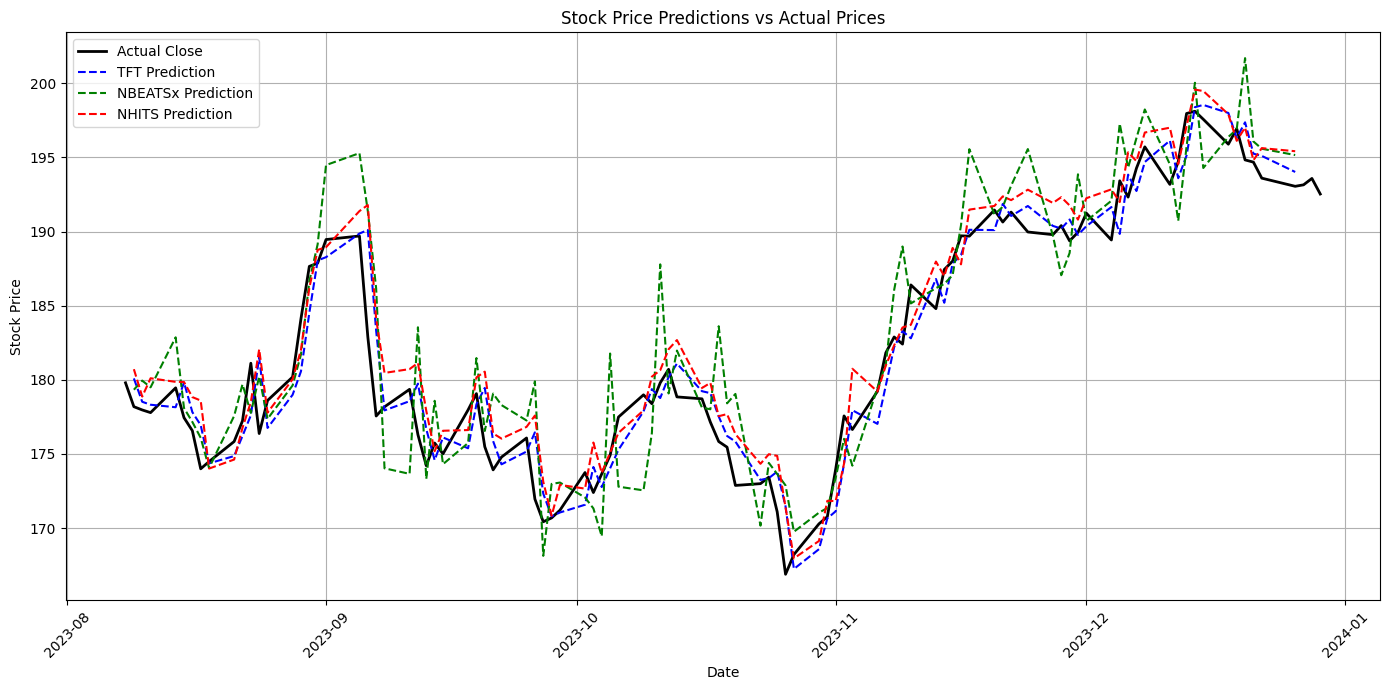

In [209]:
plt.figure(figsize=(14, 7))
plt.plot(Y_hat_df['ds'], Y_hat_df_2['Close'], label='Actual Close', color='black', linewidth=2)
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['TFT_Close'], label='TFT Prediction', color='blue', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NBEATs_Close'], label='NBEATSx Prediction', color='green', linestyle='--')
plt.plot(Y_hat_df_2['ds'], Y_hat_df_2['NHITS_Close'], label='NHITS Prediction', color='red', linestyle='--')

plt.title('Stock Price Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [210]:
mse_TFT = mse(Y_hat_df['y'], Y_hat_df['TFT'])
mae_TFT = mae(Y_hat_df['y'], Y_hat_df['TFT'])
mse_NBEATSx = mse(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mae_NBEATSx = mae(Y_hat_df['y'], Y_hat_df['NBEATSx'])
mse_NHITS = mse(Y_hat_df['y'], Y_hat_df['NHITS'])
mae_NHITS = mae(Y_hat_df['y'], Y_hat_df['NHITS'])

In [211]:
print(f"MSE TFT: {mse_TFT}")
print(f"MAE TFT: {mae_TFT}")
print(f"MSE NBEATSx: {mse_NBEATSx}")
print(f"MAE NBEATSx: {mae_NBEATSx}")
print(f"MSE NHITS: {mse_NHITS}")
print(f"MAE NHITS: {mae_NHITS}")

MSE TFT: 0.00013862307585180727
MAE TFT: 0.009193537091084924
MSE NBEATSx: 0.00037212783244063485
MAE NBEATSx: 0.01505288793347226
MSE NHITS: 0.00018740196413465608
MAE NHITS: 0.010700729420072037
